# Import

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract
import cv2
import re
from scipy.ndimage import rotate

# Regex to detect necessary text

In [2]:
r = re.compile("([A-Z]{5}[0-9]{4}[A-Z]{1})|([0-9]{2}/[0-9]{2}/[0-9]{4})")

# Display image
## Matplotlib interprets images in RGB format, but OpenCV uses BGR format

In [3]:
def disp_img(img):
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

margin = 10
# x_margin, y_margin = 10, 10

# Read image

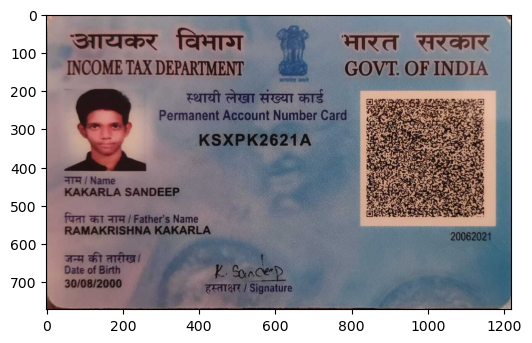

In [4]:
img = cv2.imread('../data/2.jpg') # BGR format
disp_img(img)

## Preprocessing

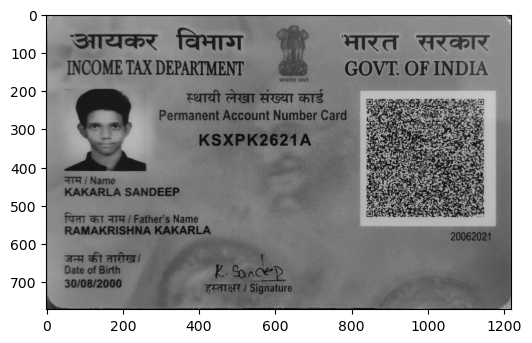

In [5]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
disp_img(img_gray)

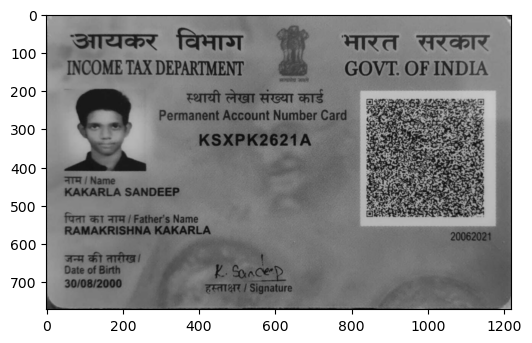

In [6]:
img_blur = cv2.GaussianBlur(img_gray, (3, 3), 0)
disp_img(img_blur)

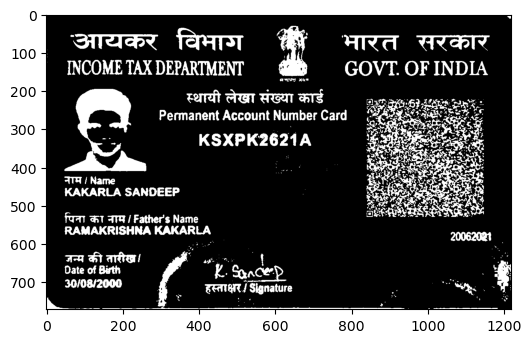

In [7]:
img_thresh = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
disp_img(img_thresh)

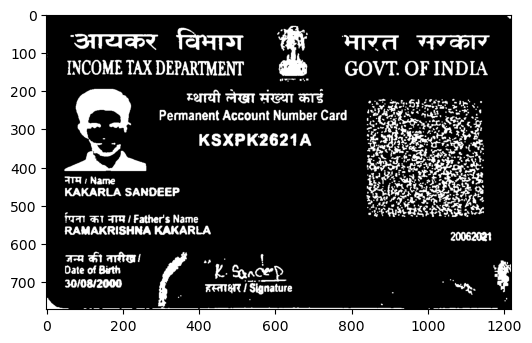

In [8]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
img_opening = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, kernel, iterations=1)

disp_img(img_opening)

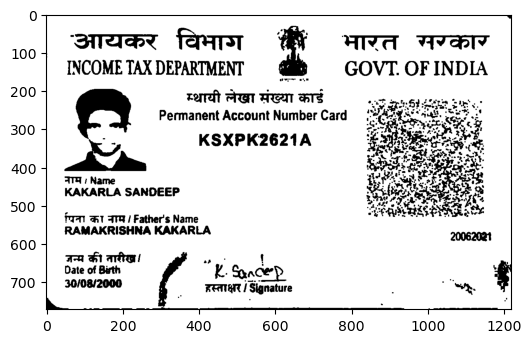

In [9]:
img_invert = 255 - img_opening
disp_img(img_invert)

# Text extraction

In [10]:
import pytesseract

# Set the path to the Tesseract executable
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Replace with the actual path

# Now you can use pytesseract.image_to_string as before


In [11]:
data = pytesseract.image_to_data(img_gray, output_type='dict')

print(data.keys())
print('Detected Text:', data['text'])

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])
Detected Text: ['', '', '', '', ' ', '', '', '', '‘Si', '', '', '', ' ', '', '', '', 'sae', 'faq', '', 'INCOME', 'TAX', 'DEPARTMENT', '', 'tareat', 'CAT', 'AAT', 'Hrs', '', '', '', 'Permanent', 'Account', 'Number', 'Card', '', '', '', 'Ad', 'UXHy', '', 'GOVT.', 'OF', 'INDIA', '', '', '', ' ', '', '', '', '  ', '', '', '', 'aTa', '/', 'Name', '', '', '', ' ', '', '', '', 'KAKARLA', 'SANDEEP', '', '', 'foal', 'aT', 'aT', '/', "Father's", 'Name', '', '', 'RAMAKRISHNA', 'KAKARLA', '', '', 'Fs', 'pr', 'eal', 'ae', 'or', 'ip', ',', 'a', ',', '', '30/08/2000', '..', 'at', '/', 'Signature', ';', 'ee', 'ne:', 'a', '', '', '', '']


In [12]:
def extract_information_from_ocr(data):
    # Initialize variables
    name = fathers_name = dob = signature = pan = None

    # Iterate through the detected text
    for i in range(len(data['text'])):
        text = data['text'][i].strip()

        # Extract 'Name'
        if 'Name' in text:
            name = ' '.join(data['text'][i+1:i+4])

        # Extract "Father's Name"
        elif "Father's Name" in text:
            fathers_name = ' '.join(data['text'][i+1:i+4])

        # Extract 'DOB'
        elif re.match(r'\d{2}/\d{2}/\d{4}', text):
            dob = text

        # Extract 'Signature'
        elif 'Signature' in text:
            signature = ' '.join(data['text'][i+1:i+4])

        # Extract 'PAN'
        elif re.match(r'[A-Z]{5}[0-9]{4}[A-Z]', text):
            pan = text

    return {'Name': name, 'Fathers Name': fathers_name, 'DOB': dob, 'Signature': signature, 'PAN': pan}

# Example usage
ocr_data = {'level': [1, 2], 'text': ['', '', '', '', 'INCOME', 'TAX', 'DEPARTMENT', '2', 'GOVTOFIND', '', '', '', 'tard', 'eran', 'Ae', 'TS', '', 'Permanent', 'Account', 'Number', 'Card', '', '', '', ' ', '', '', '', ' ', '', '', '', 'CFAPG1415C', '', 'ama', '/', 'Name', '', '', 'PAVAN', 'KUMAR', 'GODDATI', '', '', 'ffrat', '@1', 'ATH', '/', "Father's", 'Name', '', '', 'DHANAYYA', 'GODDATI', '', '', 'wa', '1', 'ariter/', 'Date', 'che', '', '12/03/1999', 'fonts', '', '', '', ' ', '', '', '', '‘Fema', '/', 'Signature']}
information = extract_information_from_ocr(ocr_data)

print("Extracted Information:")
print(information)


Extracted Information:
{'Name': '  DHANAYYA', 'Fathers Name': None, 'DOB': '12/03/1999', 'Signature': '', 'PAN': 'CFAPG1415C'}


In [13]:
bag = [(id, text) for id, text in enumerate(data['text']) if r.match(text)]
display(bag)

[(90, '30/08/2000')]

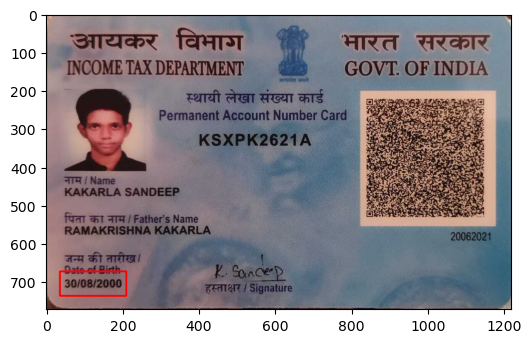

In [14]:
img_marked = img.copy()

for (id, text) in bag:
    left = data['left'][id] - margin
    top = data['top'][id] - margin
    width = data['width'][id] + 2*margin
    height = data['height'][id] + 2*margin
    cv2.rectangle(img_marked, (left, top), (left+width, top+height), (0, 0, 255), 4)

disp_img(img_marked)

In [15]:
import os
import cv2

def process_multiple_images(input_folder, output_folder):
    # Check if input folder exists
    if not os.path.exists(input_folder):
        print(f"Error: Input folder does not exist: {input_folder}")
        return

    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Get a list of all image files in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    if not image_files:
        print(f"No image files found in the folder: {input_folder}")
        return

    # Process each image
    for image_file in image_files:
        input_path = os.path.join(input_folder, image_file)
        output_path = os.path.join(output_folder, image_file)

        print(f"Processing {input_path} -> {output_path}")

        # Read the image
        img = cv2.imread(input_path)
        if img is None:
            print(f"Failed to read image: {input_path}")
            continue

        # Convert to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Save the grayscale image to the output folder
        cv2.imwrite(output_path, gray_img)
        print(f"Saved grayscale image: {output_path}")


In [16]:
import cv2
import numpy as np

def detect_signature(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply edge detection using Canny
    edges = cv2.Canny(gray, 50, 150)

    # Find contours in the image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > 1000]

    # Assuming the largest contour is the signature
    if filtered_contours:
        largest_contour = max(filtered_contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        return x, y, x + w, y + h
    else:
        return None

def disp_img(image):
    # Assuming you have a function to display the image
    cv2.imshow("Marked Image", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Your existing image and bag data
img = cv2.imread('../data/2.jpg')
bag = [(0, "Text1"), (1, "Text2")]  # Adjust indices to match your actual data
data = {'left': [100, 200], 'top': [150, 300], 'width': [50, 100], 'height': [30, 40]}  # Sample data
margin = 5  # Adjust the margin based on your requirements

# Modify the code to detect and mark the signature
img_marked = img.copy()

# Detect and mark the signature
signature_coordinates = detect_signature(img)
if signature_coordinates:
    left, top, right, bottom = signature_coordinates
    cv2.rectangle(img_marked, (left, top), (right, bottom), (0, 0, 255), 4)

# Draw rectangles around other regions based on your existing logic
for (id, text) in bag:
    if id < len(data['left']):
        left = data['left'][id] - margin
        top = data['top'][id] - margin
        width = data['width'][id] + 2 * margin
        height = data['height'][id] + 2 * margin
        cv2.rectangle(img_marked, (left, top), (left + width, top + height), (0, 0, 255), 4)

# Display the marked image
disp_img(img_marked)


In [17]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('../data/2.jpg') # BGR format
disp_img(img)